# Cеминар 6: Решающие деревья

Сами по себе решающие деревья используются в машинном обучении относительно редко, однако очень распространены методы, основанные на их композиции - ансамблях (Random Forest, XGBoost, LightGBM), о которых мы поговорим на дальнейших занятиях.

## Линейные модели или решающие деревья?

Раньше мы разбирали только линейные модели, которые имеют совсем другую природу по отношению к решающим деревьям. Можно ли сказать, что какой-то из этих двух типов моделей всегда лучше? Нет. В зависимости от пространственной структуры данных, один из них будет работать лучше:

- Линейная модель, если данные хорошо линейно разделимы

- Решающие деревья, если данные плохо линейно разделимы (присутствуют только кусочно-линейные или нелинейные зависимости)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


%matplotlib inline
plt.rcParams["figure.figsize"] = (5,5)

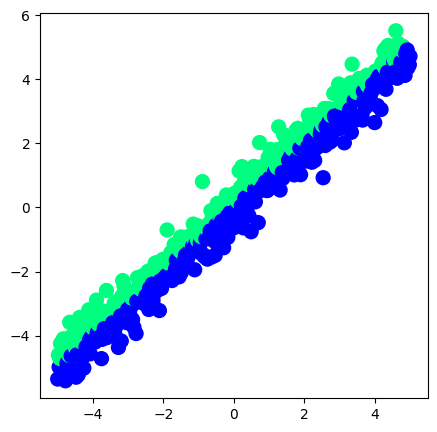

In [2]:
np.random.seed(13)
n = 500
X = np.zeros(shape=(n, 2))

X[:, 0] = np.linspace(-5, 5, 500)
X[:, 1] = X[:, 0] + 0.5 * np.random.normal(size=n)
y = (X[:, 1] > X[:, 0]).astype(int)
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap="winter")
plt.show()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

lr = LogisticRegression(random_state=13)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(f"Linear model accuracy: {accuracy_score(y_pred_lr, y_test):.2f}")

Linear model accuracy: 0.99


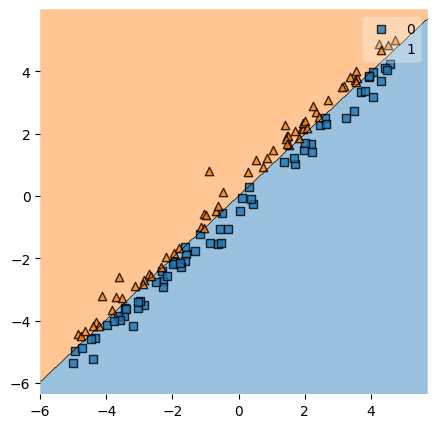

In [4]:
# !pip install mlxtend
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test, y_test, lr)

plt.show()

In [5]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=13)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print(f"Decision tree accuracy: {accuracy_score(y_pred_dt, y_test):.2f}")

Decision tree accuracy: 0.86


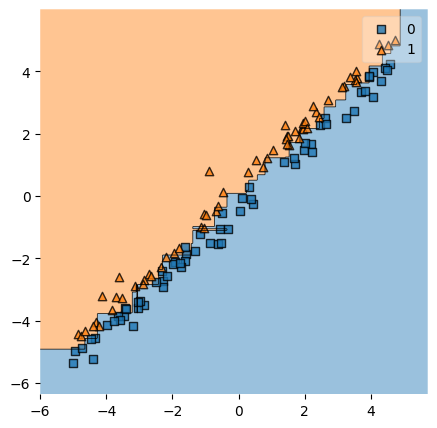

In [6]:
plot_decision_regions(X_test, y_test, dt)
plt.show()

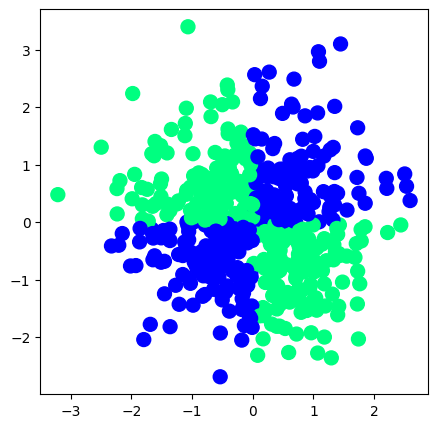

In [7]:
np.random.seed(13)
X = np.random.randn(500, 2)
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0).astype(int)
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap="winter")
plt.show()

Linear model accuracy: 0.39


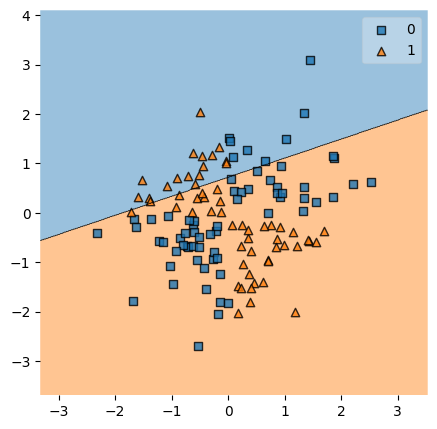

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

lr = LogisticRegression(random_state=13)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(f"Linear model accuracy: {accuracy_score(y_pred_lr, y_test):.2f}")

plot_decision_regions(X_test, y_test, lr)
plt.show()

Decision Tree accuracy: 0.97


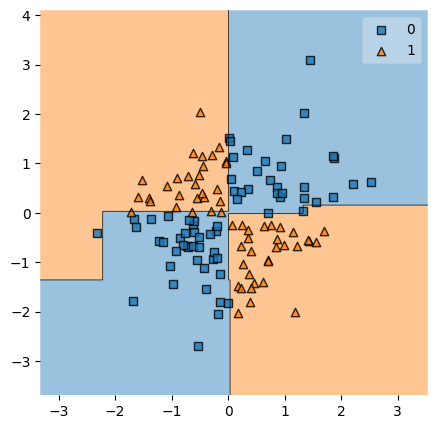

In [9]:
dt = DecisionTreeClassifier(random_state=13)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print(f"Decision Tree accuracy: {accuracy_score(y_pred_dt, y_test):.2f}")

plot_decision_regions(X_test, y_test, dt)
plt.show()

## Переобучение

На лекции рассказывалось, что решающие деревья способны переобучиться под любую выборку, если их никак не регуляризовать: при большом количестве листьев для каждого объекта может выделиться своя область в признаковом пространстве. По сути дерево просто выучивает обучающую выборку, но выделяет никаких закономерностей среди данных. Давайте убедимся в этом эффекте на практике, сгенерировав два трудноразделимых множества объектов.

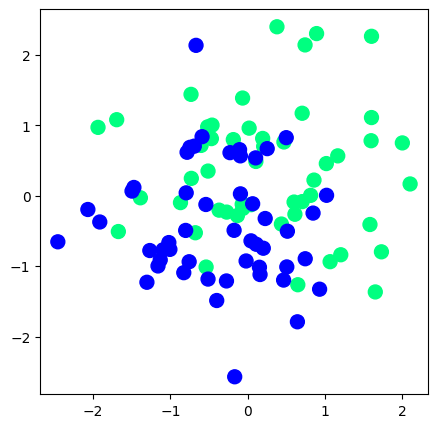

In [10]:
np.random.seed(13)
n = 100
X = np.random.normal(size=(n, 2))
X[:50, :] += 0.25
X[50:, :] -= 0.25
y = np.array([1] * 50 + [0] * 50)
plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap="winter")
plt.show()

Посмотрим, как влияют разные значения гиперпараметров решающего дерева на его структуру:

- `max_depth`: максимальная глубина дерева
- `min_samples_leaf`: минимальное число объектов в вершине дерева, необходимое для того, чтобы она стала листовой

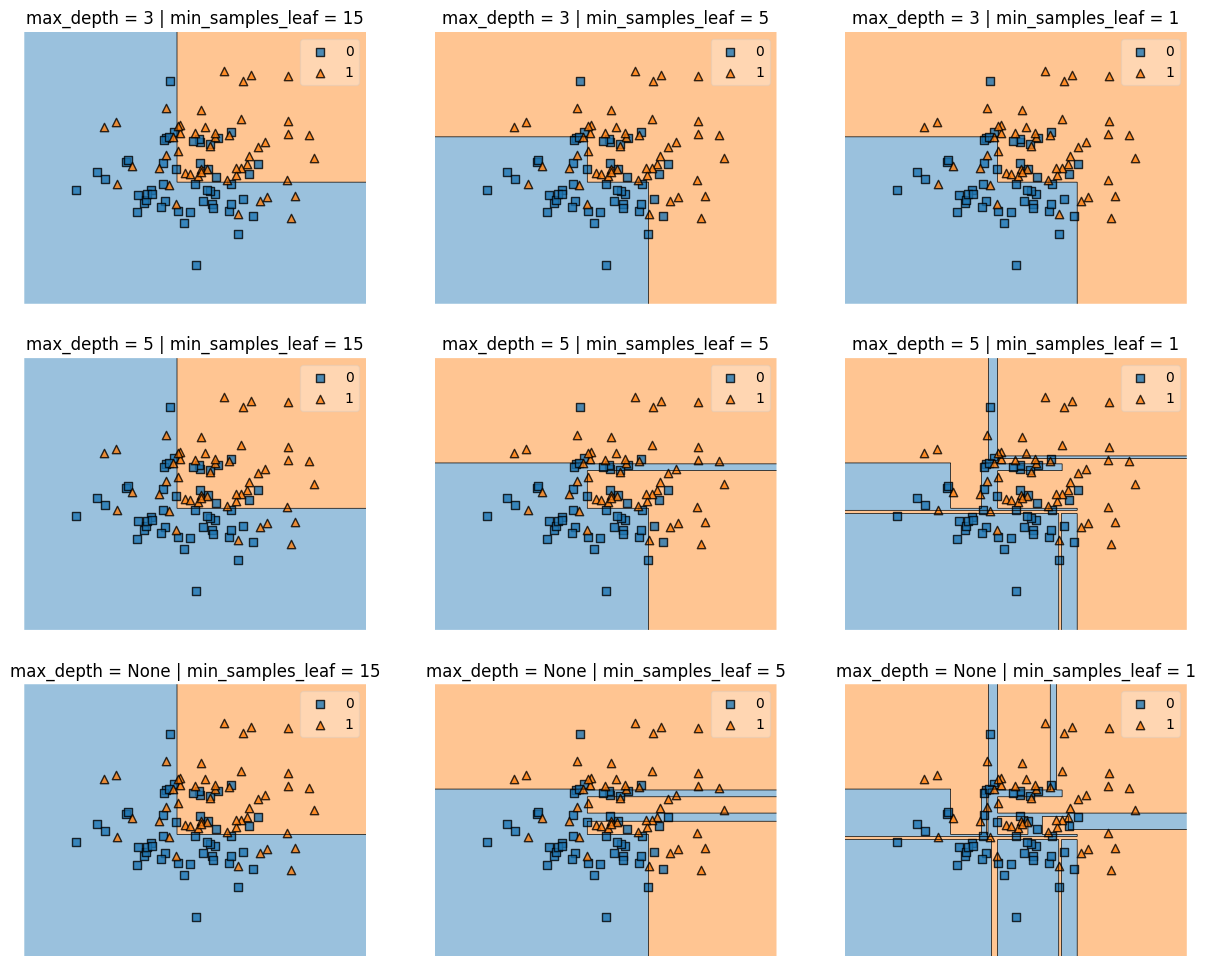

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i, max_depth in enumerate([3, 5, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=13)
        dt.fit(X, y)
        ax[i][j].set_title("max_depth = {} | min_samples_leaf = {}".format(max_depth, min_samples_leaf))
        ax[i][j].axis("off")
        plot_decision_regions(X, y, dt, ax=ax[i][j])
        
plt.show()

На любой выборке (исключая те, где есть объекты с одинаковыми значениями признаков, но разными ответами) можно получить нулевую ошибку - с помощью максимально переобученного дерева:

Decision tree accuracy: 1.00


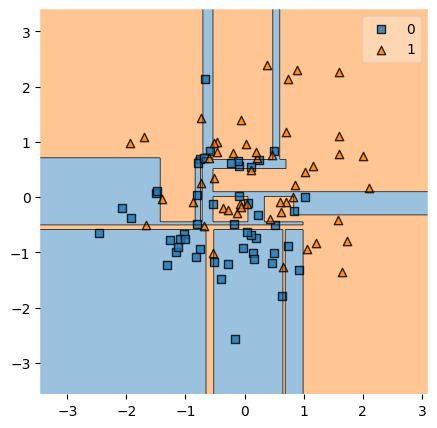

In [12]:
dt = DecisionTreeClassifier(max_depth=None, min_samples_leaf=1, random_state=13)
dt.fit(X, y)

print(f"Decision tree accuracy: {accuracy_score(y, dt.predict(X)):.2f}")

plot_decision_regions(X, y, dt)
plt.show()

## Неустойчивость

Посмотрим, как будет меняться структура дерева, если брать для обучения разные 90%-ые подвыборки исходной выборки.

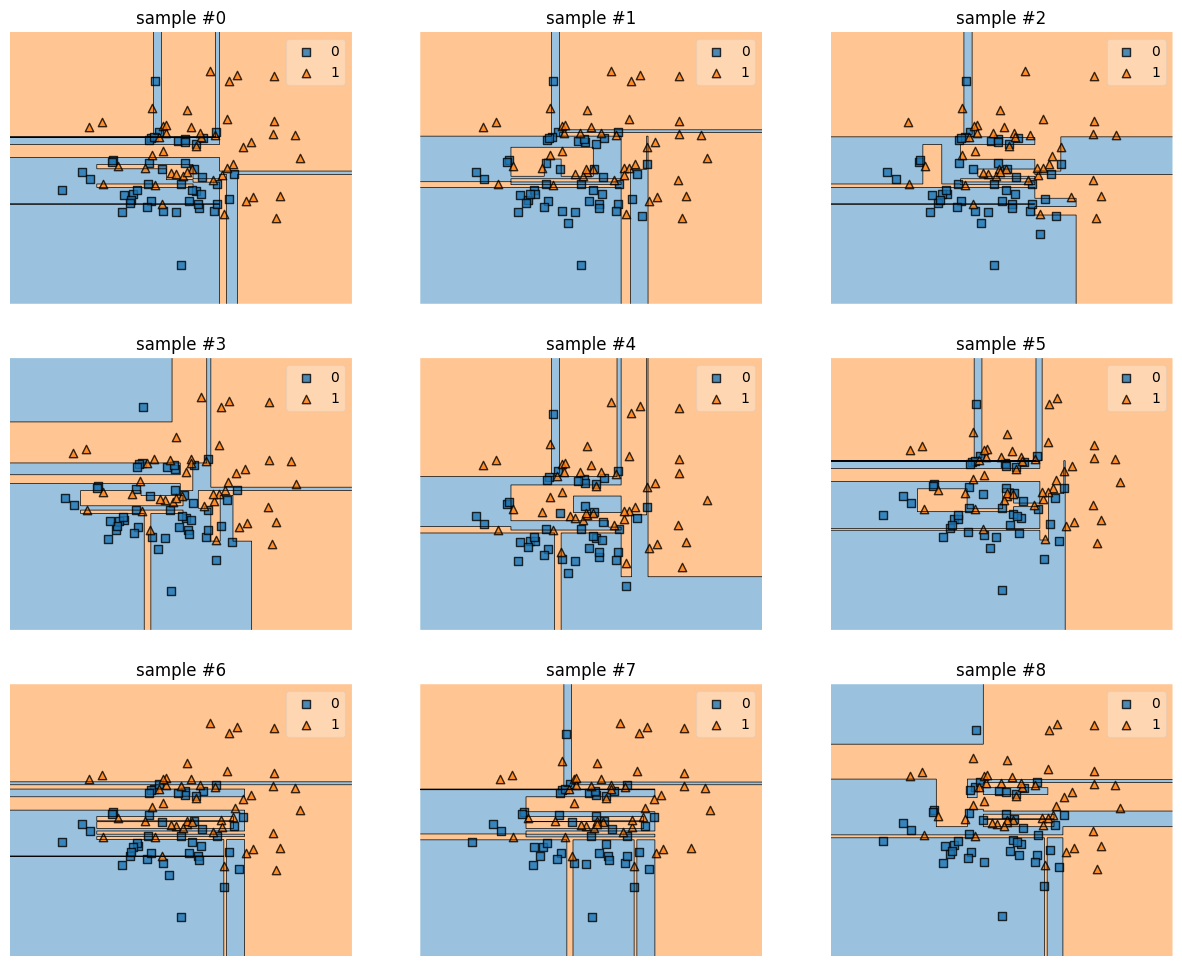

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i in range(3):
    for j in range(3):
        seed_idx = 3 * i + j
        np.random.seed(seed_idx)
        dt = DecisionTreeClassifier(random_state=13)
        idx_part = np.random.choice(len(X), replace=False, size=int(0.9 * len(X)))
        X_part, y_part = X[idx_part, :], y[idx_part]
        dt.fit(X_part, y_part)
        ax[i][j].set_title("sample #{}".format(seed_idx))
        ax[i][j].axis("off")
        plot_decision_regions(X_part, y_part, dt, ax=ax[i][j])
        
plt.show()

## Практика

In [14]:
import pandas as pd

from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()

In [15]:
print(housing["DESCR"])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [16]:
housing.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [17]:
housing["feature_names"]

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [19]:
X = pd.DataFrame(data=housing["data"], columns=housing["feature_names"])
y = housing["target"]

print(f"Data shape: {X.shape}")
X.head(10)

Data shape: (20640, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25


In [20]:
y[:5]

array([4.526, 3.585, 3.521, 3.413, 3.422])

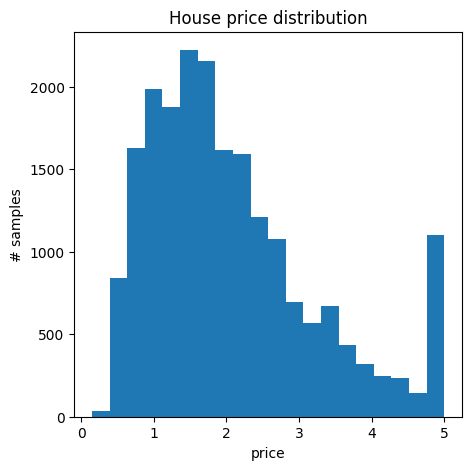

In [21]:
plt.title("House price distribution")
plt.xlabel("price")
plt.ylabel("# samples")
plt.hist(y, bins=20)
plt.show()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15480, 8), (5160, 8), (15480,), (5160,))

### Решающее дерево: sklearn

In [23]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree

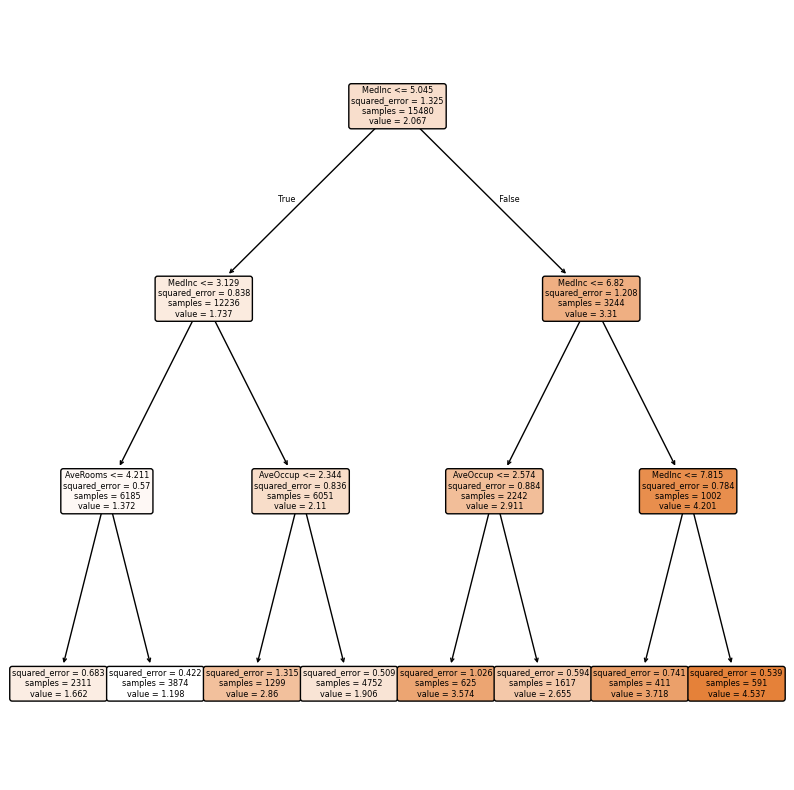

In [24]:
dt = DecisionTreeRegressor(max_depth=3, random_state=13)
dt.fit(X_train, y_train)

plt.figure(figsize=(10,10))
plot_tree(dt, feature_names=X.columns, filled=True, rounded=True)
plt.show()

In [25]:
mean_squared_error(y_test, dt.predict(X_test))

0.6352419064695592

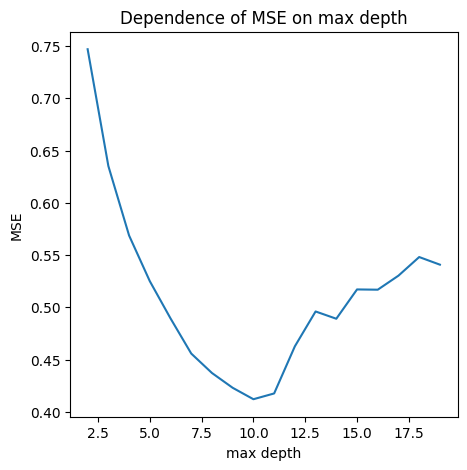

In [26]:
max_depth_array = range(2, 20)
mse_array = []

for max_depth in max_depth_array:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=13)
    dt.fit(X_train, y_train)
    mse_array.append(mean_squared_error(y_test, dt.predict(X_test)))

plt.plot(max_depth_array, mse_array)
plt.title("Dependence of MSE on max depth")
plt.xlabel("max depth")
plt.ylabel("MSE")
plt.show()

In [27]:
pd.DataFrame({
    "max_depth": max_depth_array,
    "MSE": mse_array
}).sort_values(by="MSE").reset_index(drop=True)

,max_depth,MSE
0,10,0.412125
1,11,0.417647
2,9,0.423044
3,8,0.437202
4,7,0.455806
5,12,0.462736
6,14,0.489129
7,6,0.489436
8,13,0.496086
9,16,0.516918


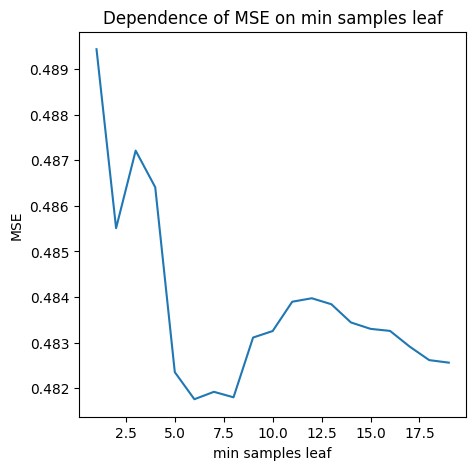

In [28]:
min_samples_leaf_array = range(1, 20)
mse_array = []

for min_samples_leaf in min_samples_leaf_array:
    dt = DecisionTreeRegressor(max_depth=6, min_samples_leaf=min_samples_leaf, random_state=13)
    dt.fit(X_train, y_train)
    mse_array.append(mean_squared_error(y_test, dt.predict(X_test)))
    
plt.plot(min_samples_leaf_array, mse_array)
plt.title("Dependence of MSE on min samples leaf")
plt.xlabel("min samples leaf")
plt.ylabel("MSE")
plt.show()

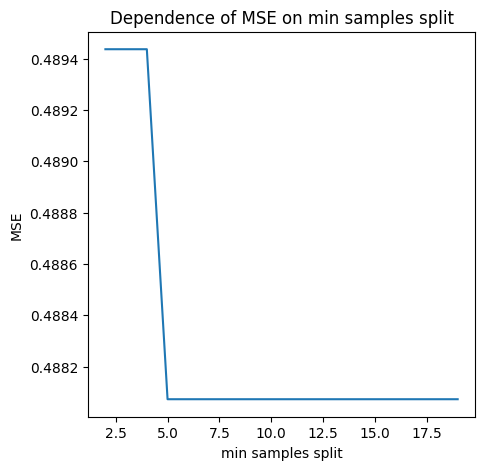

In [29]:
min_samples_split_array = range(2, 20)
mse_array = []

for min_samples_split in min_samples_split_array:
    dt = DecisionTreeRegressor(max_depth=6, min_samples_split=min_samples_split, random_state=13)
    dt.fit(X_train, y_train)
    mse_array.append(mean_squared_error(y_test, dt.predict(X_test)))

plt.plot(min_samples_split_array, mse_array)
plt.title("Dependence of MSE on min samples split")
plt.xlabel("min samples split")
plt.ylabel("MSE")
plt.show()

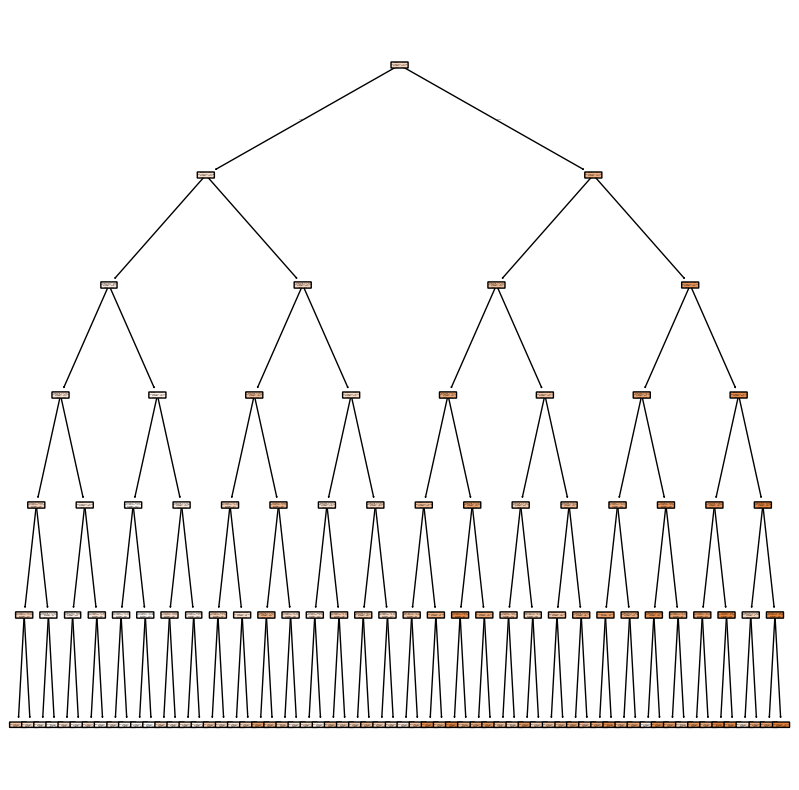

In [31]:
dt = DecisionTreeRegressor(max_depth=6, random_state=13)
plt.figure(figsize=(10,10))
dt.fit(X_train, y_train)
plot_tree(dt, feature_names=X.columns, filled=True, rounded=True)
plt.show()

In [32]:
mean_squared_error(y_test, dt.predict(X_test))

0.4894363278261739

In [33]:
dt.feature_importances_

array([0.72305995, 0.04598873, 0.02861573, 0.00145045, 0.00239386,
       0.13992142, 0.03660693, 0.02196293])

In [34]:
pd.DataFrame({
    "feature": X.columns,
    "importance": dt.feature_importances_
}).sort_values(by="importance", ascending=False).reset_index(drop=True)

,feature,importance
0,MedInc,0.723060
1,AveOccup,0.139921
2,HouseAge,0.045989
3,Latitude,0.036607
4,AveRooms,0.028616
5,Longitude,0.021963
6,Population,0.002394
7,AveBedrms,0.001450


Влияет ли стандартизация (масштабирование) признаков на результат работы решающего дерева?

In [ ]:
X_train.head()

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(sc.transform(X_test), columns=X_test.columns, index=X_test.index)
X_train_scaled.head()

In [ ]:
print("No scaling is applied\n")

for max_depth in [3, 6]:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=13)
    dt.fit(X_train, y_train)
    print(f"MSE on test set for depth {max_depth}: {mean_squared_error(y_test, dt.predict(X_test)):.2f}")

In [ ]:
print("Standard scaling is applied\n")

for max_depth in [3, 6]:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=13)
    dt.fit(X_train_scaled, y_train)
    print(f"MSE on test set for depth {max_depth}: {mean_squared_error(y_test, dt.predict(X_test_scaled)):.2f}")